In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from scipy.stats import multivariate_normal


# you can choose one of the following package for image reading/processing

import cv2
import PIL


#**1. Support Vector Machine**

##**2.OVR OVO**  
**one versus the rest:** 如果有N個class，會製造N個model 每個model i會判斷x是否屬於class i,但是如果出現多個model都認定x屬於該class，或者不屬於任何class就需要額外的criterion處理  

**one versus one:** 如果有N個class，會製造(N*(N-1)/2)個model 每個分類0v1,0v2....0vN,N-1vN 然後根據每個model的結果投票最後選擇票數最高的選項，需要特別處裡的情況只有最高票數的class有多個，可以引入額外的criterion進行選擇，也可以很直覺的任選其中一個就好，因為都是最有可能的選項  

**選擇使用one versus one:**相較於OVR,需要引入額外的criterion處理各種例外情況,OVO的例外處理相對簡單而且也相對直覺，model數更多可能也會提供相對穩定的結果，所以這邊使用OVO

##**Linear Kernel**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/x_train.csv",header= None)/255
label = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/t_train.csv",header= None)

data_numpy=data.to_numpy()
label_numpy=label.to_numpy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


check if data is correct

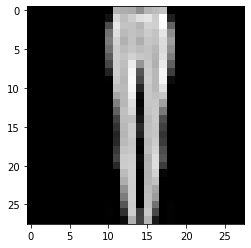

In [3]:
plt.imshow(data_numpy[0].reshape((28,28)),cmap="gray")

In [4]:
def PCA(data, d):
  new_data = data - np.mean(data, axis=0)
  U, Sigma, Vh = np.linalg.svd(new_data.T)
  pca_data = np.dot(new_data, U[:,:d])
  return pca_data

In [5]:
def linear_kernel(x1,x2):
    return (x1.reshape(1,-1)@x2.reshape(-1,1)).item()
def linear_phi(x):
    return x
def poly_phi(x):
    x1,x2=x
    return np.array([x1**2,1.4142135*x1*x2,x2**2])
def poly_kernel(x1,x2):
    return ((x1.reshape(1,-1)@x2.reshape(-1,1)).item())**2

In [6]:
data_pca=PCA(data_numpy,2)
clf=svm.SVC(kernel='linear',degree=2,C=1,decision_function_shape='ovo')
clf.fit(data_pca,label.to_numpy().ravel())
#print(clf.score(data_pca,label.to_numpy().ravel()))

SVC(C=1, decision_function_shape='ovo', degree=2, kernel='linear')

**Building three model**  
Find suppoert vectors and corresponding alpha given by sklearn

In [7]:
#index 0 for 0v1, 1 for 0v2 2 for 1v2
v=(clf.support_vectors_)
[len_0,len_1,len_2]=clf.n_support_

"""
#ndarray
vector_0=v[0:len_0]
vector_1=v[len_0:(len_0+len_1)]
vector_2=v[-5:]
"""
#list
vector_0=[i for i in v[0:len_0]]
vector_1=[i for i in v[len_0:(len_0+len_1)]]
vector_2=[i for i in v[-5:]]
support_vectors=[vector_0,vector_1,vector_2]

dual_coef=clf.dual_coef_
alpha_01=dual_coef[0][0:(len_0+len_1)]
alpha_02=np.concatenate([dual_coef[1][0:len_0],dual_coef[0][-len_2:]])
alpha_12=np.concatenate([dual_coef[1][len_0:(len_0+len_1)],dual_coef[1][-len_2:]])
alpha_list=[alpha_01,alpha_02,alpha_12]

In [8]:
#index 0 for 0v1, 1 for 0v2 2 for 1v2
def get_weight(alpha_list,support_vectors,kernel="linear"):
    if kernel=="linear":
        kernel=linear_kernel
        phi=linear_phi
    else:
        kernel=poly_kernel
        phi=poly_phi
    weight_list=[0]*3
    #model0 0v1
    for i,vec in enumerate(support_vectors[0]+support_vectors[1]):
        weight_list[0]+=(phi(vec)*alpha_list[0][i])
    #model1 0v2
    for i,vec in enumerate(support_vectors[0]+support_vectors[2]):
        weight_list[1]+=(phi(vec)*alpha_list[1][i])
    #model2 1v2
    for i,vec in enumerate(support_vectors[1]+support_vectors[2]):
        weight_list[2]+=(phi(vec)*alpha_list[2][i])
    return weight_list

In [9]:
#M for <1  precisely <C given C=1
#S for <=1
def get_bias(alpha_list,support_vectors,kernel="linear",C=1):
    if kernel=="linear":
        kernel=linear_kernel
        phi=linear_phi
    else:
        kernel=poly_kernel
        phi=poly_phi
    bias_list=[0]*3
    subset_list=[support_vectors[0]+support_vectors[1],
                 support_vectors[0]+support_vectors[2],
                 support_vectors[1]+support_vectors[2]]
    #model 0 for 0v1, 1 for 0v2 2 for 1v2
    for model, subset in enumerate(subset_list):     
        countM=0
        for i,vec1 in enumerate(subset):
            if alpha_list[model][i]==0:
                continue
            if abs(alpha_list[model][i])==C: #M for 0< <1
                continue
            countM+=1
            tn=np.sign(alpha_list[model][i]) 
            S_sum=0
            for j,vec2 in enumerate(subset): #S for <=1
                S_sum+=(kernel(vec1,vec2)*alpha_list[model][j])
            bias_list[model]+=tn-S_sum.item() 
        bias_list[model]/=countM
    return bias_list

In [10]:
weight_list=get_weight(alpha_list,support_vectors,kernel="linear")
print(weight_list)
#print(clf.coef_) #for check
bias_list=get_bias(alpha_list,support_vectors,kernel="linear")
print(bias_list)
#print(clf.intercept_) #for check

[array([-0.11943977, -0.71771329]), array([0.98189889, 1.14167465]), array([0.70406366, 0.99662907])]
[0.8682481784993056, 4.4968852147062455, 1.8412193321151553]


In [11]:
def predict(X,weight_list,bias_list): #X.shape shoudl be(N,D)
    """
    Parameters
    ----------
    X: shape shoudl be(N,D) D is dimension of phi(xi)
    weight_list: list of weight(D,) for each model
    bias_list: list of bias(scalar) for each model
    #model's amount = choices*(choices-1)/2

    Returns
    -------
    predict_label:shape(N,) 
    """
    N=len(X)
    vote=np.zeros((N,3))
    y0=weight_list[0].reshape(1,-1)@X.T+bias_list[0]  #1,300
    y1=weight_list[1].reshape(1,-1)@X.T+bias_list[1]
    y2=weight_list[2].reshape(1,-1)@X.T+bias_list[2]
    for i in range(N):
        if y0[0][i]>0:
            vote[i][0]+=1
        else:
            vote[i][1]+=1
        if y1[0][i]>0:
            vote[i][0]+=1
        else:
            vote[i][2]+=1
        if y2[0][i]>0:
            vote[i][1]+=1
        else:
            vote[i][2]+=1
    return np.argmax(vote,axis=1)

**Ploting Stage**

In [12]:
#reference:https://github.com/andy6804tw/2021-13th-ironman/blob/main/11.SVM/11.1.SVM(Classification-iris).ipynb
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [13]:
subdata_list=[]
for i in range(3):
    index=np.where(label_numpy.reshape(-1) == i)
    subdata_list.append(data_pca[index])

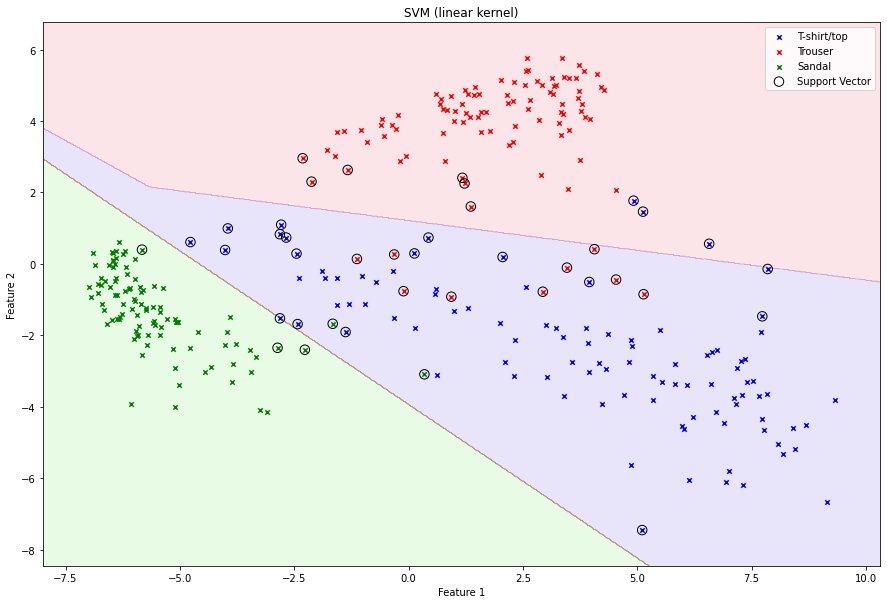

In [14]:
X0, X1 = data_pca[:, 0], data_pca[:, 1]
x_, y_ = make_meshgrid(X0, X1) #坐標軸每個點(顏色解析度) ex:在(10,10)中平均取1000或10000個點
#cotour
points=np.c_[x_.ravel(), y_.ravel()]
predictions=predict(points,weight_list,bias_list)

#for i in range(len(points)):
#    predictions.append(predict(points[i],weight_list,bias_list))
N,D=x_.shape
Z=np.array(predictions).reshape((N,D))
plt.contourf(x_, y_,Z,cmap=plt.cm.brg, alpha=0.1)
#scatter

plt.scatter(subdata_list[0][:,0], subdata_list[0][:,1],s=20, c='b', marker='x', label="T-shirt/top")
plt.scatter(subdata_list[1][:,0], subdata_list[1][:,1],s=20, c='r', marker='x', label="Trouser")
plt.scatter(subdata_list[2][:,0], subdata_list[2][:,1],s=20, c='g', marker='x', label="Sandal")
plt.scatter(v[:,0], v[:,1],s=90, facecolors='none', edgecolors='k', linewidths=1,label="Support Vector")

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('SVM (linear kernel)')
fig = plt.gcf()
fig.set_size_inches(15, 10)


##**Polynomial (degree=2)**

In [15]:
clf=svm.SVC(kernel='poly',degree=2,C=1,decision_function_shape='ovo')
clf.fit(data_pca,label.to_numpy().ravel())
#print(clf.score(data_pca,label.to_numpy().ravel()))
print(clf.n_support_)

[47 48 37]


In [16]:
#index 0 for 0v1, 1 for 0v2 2 for 1v2
v=(clf.support_vectors_)
[len_0,len_1,len_2]=clf.n_support_

"""
#ndarray
vector_0=v[0:len_0]
vector_1=v[len_0:(len_0+len_1)]
vector_2=v[-5:]
"""
#list
vector_0=[i for i in v[0:len_0]]
vector_1=[i for i in v[len_0:(len_0+len_1)]]
vector_2=[i for i in v[-len_2:]]
support_vectors=[vector_0,vector_1,vector_2]

dual_coef=clf.dual_coef_
alpha_01=dual_coef[0][0:(len_0+len_1)]
alpha_02=np.concatenate([dual_coef[1][0:len_0],dual_coef[0][-len_2:]])
alpha_12=np.concatenate([dual_coef[1][len_0:(len_0+len_1)],dual_coef[1][-len_2:]])
alpha_list=[alpha_01,alpha_02,alpha_12]

In [17]:
weight_list=get_weight(alpha_list,support_vectors,kernel="poly")
bias_list=get_bias(alpha_list,support_vectors,kernel="poly")
print(weight_list)
print(bias_list) 

[array([ 20.68556111, -76.44761197, -99.09738118]), array([ -57.51112119, -105.06438722,  -12.71266284]), array([-74.1673779 , -24.24748632,  72.35598938])]
[368.2304360512287, 939.8615110534291, 649.5093299847226]


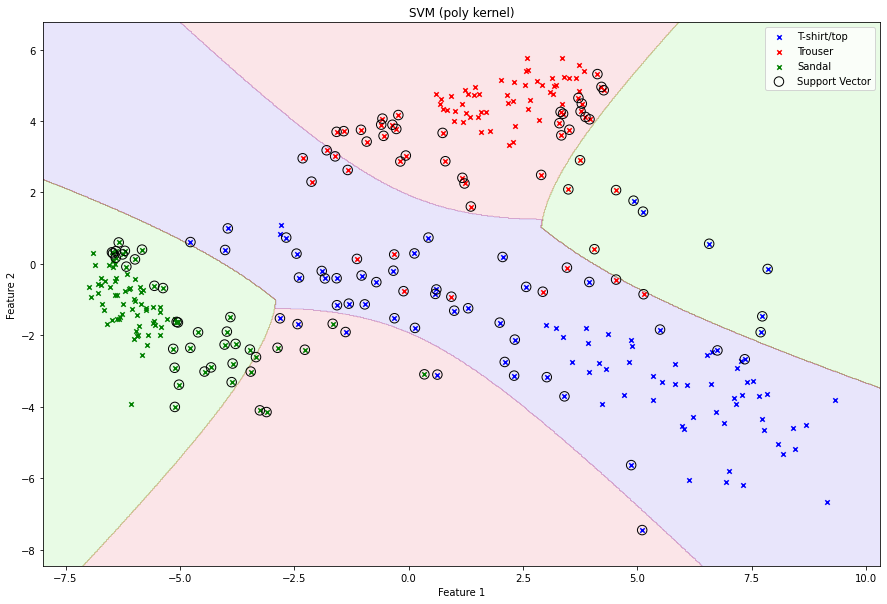

In [18]:
X0, X1 = data_pca[:, 0], data_pca[:, 1]
x_, y_ = make_meshgrid(X0, X1) #坐標軸每個點(顏色解析度) ex:在(10,10)中平均取1000或10000個點
#cotour
points=np.c_[x_.ravel()*x_.ravel(),1.4142135*x_.ravel()*y_.ravel() ,y_.ravel()*y_.ravel()]
predictions=predict(points,weight_list,bias_list)

#for i in range(len(points)):
#    predictions.append(predict(points[i],weight_list,bias_list))
N,D=x_.shape
Z=np.array(predictions).reshape((N,D))
plt.contourf(x_, y_,Z,cmap=plt.cm.brg, alpha=0.1)
#scatter

plt.scatter(subdata_list[0][:,0], subdata_list[0][:,1],s=20, c='b', marker='x', label="T-shirt/top")
plt.scatter(subdata_list[1][:,0], subdata_list[1][:,1],s=20, c='r', marker='x', label="Trouser")
plt.scatter(subdata_list[2][:,0], subdata_list[2][:,1],s=20, c='g', marker='x', label="Sandal")
plt.scatter(v[:,0], v[:,1],s=90, facecolors='none', edgecolors='k', linewidths=1,label="Support Vector")

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('SVM (poly kernel)')
fig = plt.gcf()
fig.set_size_inches(15, 10)

#**2. Gaussian Mixture Model**

##**K-mean**

In [19]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/data//hw3.jpg") #read into BGR

In [20]:
def dist(p1,p2):
    return np.dot(p1-p2,p1-p2)

In [21]:
def K_mean(img,K,d=3):

    means = np.zeros((K, d))
    N, M, _ = img.shape
    mean_list = [[0, 0, 0] for i in range(K)]
    sum_list = [[0, 0, 0] for i in range(K)]
    count_list = [0 for i in range(K)]
    assign_map = np.zeros((N, M))

    mean_list = [np.zeros(3) for i in range(K)]
    for i in range(K):
        mean_list[i]=np.array([255/(K+1)*i]*3)
    print(mean_list)
    iteration = 50
    for t in range(iteration):
        sum_list = [np.zeros(3) for i in range(K)]
        count_list = [0 for i in range(K)]
        last_mean=mean_list
        for i in range(N):
            for j in range(M):
                cur_dist = [0 for i in range(K)]
                for k in range(K):
                    cur_dist[k] = dist(img[i][j], mean_list[k])

                assignment = np.argmin(cur_dist)
                assign_map[i][j] = assignment
                sum_list[assignment] += img[i][j]
                count_list[assignment] += 1

        mean_list = [sum_list[i]/(count_list[i]+0.000001) for i in range(K)] #in case of divide by 0
        
        cur_sum=0
        for i in range(K):
            cur_sum+=abs(np.sum(last_mean[i]-mean_list[i]))
        #print(cur_sum)
        if cur_sum==0:
            break
        last_mean=mean_list #don't need list.copy()?
        #print(mean_list)
        
    img_K=np.zeros((N,M,3))
    for i in range(N):
        for j in range(M):
            img_K[i][j]=mean_list[int(assign_map[i][j])]
    img_K=img_K.astype("int32")
    print(mean_list)
    return img_K,mean_list,assign_map

In [22]:
"""
img_K5=np.zeros((N,M,3))
for i in range(N):
    for j in range(M):
        img_K5[i][j]=mean_list[int(assign_map[i][j])]
img_K5=img_K5.astype("int32")
"""
img_list=[]
means_list=[]
k_list=[2,3,7,20]
for k in k_list:
    img_k,means,_=K_mean(img,k)
    img_list.append(img_k)
    means_list.append(means)

[array([0., 0., 0.]), array([85., 85., 85.])]
[array([37.16482634, 68.26272636, 35.27817707]), array([147.4240686 , 165.62772749, 176.97598856])]
[array([0., 0., 0.]), array([63.75, 63.75, 63.75]), array([127.5, 127.5, 127.5])]
[array([22.98903961, 54.14881041, 24.69622393]), array([ 90.04034777, 119.74985254,  84.3240055 ]), array([163.62365099, 178.06550582, 201.75619667])]
[array([0., 0., 0.]), array([31.875, 31.875, 31.875]), array([63.75, 63.75, 63.75]), array([95.625, 95.625, 95.625]), array([127.5, 127.5, 127.5]), array([159.375, 159.375, 159.375]), array([191.25, 191.25, 191.25])]
[array([16.68831563, 40.97466838, 18.5748686 ]), array([30.09196935, 72.41047105, 32.77840522]), array([ 72.01711491, 101.38777506,  59.11589242]), array([105.11669773, 139.53932649,  81.58016779]), array([102.57285626, 123.81782117, 148.77235275]), array([149.78354608, 165.97542466, 190.04678861]), array([199.20270577, 208.75511133, 229.8369689 ])]
[array([0., 0., 0.]), array([12.14285714, 12.1428571

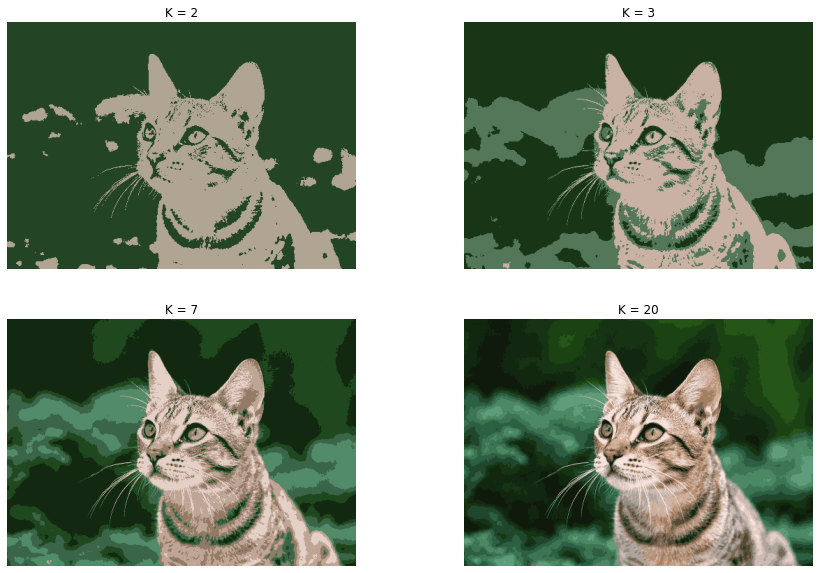

-----------means of K=2---------
[37.16482634 68.26272636 35.27817707]
[147.4240686  165.62772749 176.97598856]
-----------means of K=3---------
[22.98903961 54.14881041 24.69622393]
[ 90.04034777 119.74985254  84.3240055 ]
[163.62365099 178.06550582 201.75619667]
-----------means of K=7---------
[16.68831563 40.97466838 18.5748686 ]
[30.09196935 72.41047105 32.77840522]
[ 72.01711491 101.38777506  59.11589242]
[105.11669773 139.53932649  81.58016779]
[102.57285626 123.81782117 148.77235275]
[149.78354608 165.97542466 190.04678861]
[199.20270577 208.75511133 229.8369689 ]
-----------means of K=20---------
[12.43786982 26.08138016 15.2200876 ]
[16.88218459 39.07321727 17.31533508]
[20.49435015 51.19927718 22.1653781 ]
[19.40355244 66.16483886 26.24833479]
[24.57737893 85.20013545 38.70527147]
[45.51632383 71.61653141 32.88450651]
[66.10211267 96.58774266 45.97972973]
[ 83.4884507  116.26910797  61.44169014]
[100.75194561 136.43355333  77.22116047]
[121.93177385 156.41542124  95.06779292

In [23]:
fig, ax = plt.subplots(2,2)

for i in range(4):
    ax[i//2,i%2].set_title("K = {}".format(k_list[i]))
    ax[i//2,i%2].imshow(img_list[i][:,:,::-1]) #BGR to RGB
    ax[i//2,i%2].axis("off")
"""
i+=1
ax[i//2,i%2].set_title("original")
ax[i//2,i%2].imshow(img[:,:,::-1])
ax[i//2,i%2].axis("off")
"""
fig.set_size_inches(15, 10)
plt.show()
cur=0
for k in k_list:
    print("-----------means of K={}---------".format(k))
    l=means_list[cur]
    for mean in l:
        print(mean)
    cur+=1


##**GMM**

In [24]:
def respons(X,pi_list,mean_list,cov_list): #return R(Zn~) [k=0,k=1.......]
    #X(N,3)
    K=len(mean_list)
    N=len(X)
    pdf_list=[]
    pdf_sum=np.zeros(N)

    for i in range(K):
        pdf=pi_list[i]*multivariate_normal.pdf(X,mean_list[i],cov_list[i],allow_singular=True)
        pdf_list.append(pdf)
        pdf_sum+=pdf
    R=np.array(pdf_list)
    return np.divide(R,pdf_sum).T
def log_likelihood(X,pi_list,mean_list,cov_list):
    K=len(mean_list)
    N=len(X)
    pdf_list=[]
    pdf_sum=np.zeros(N)

    for i in range(K):
        pdf=pi_list[i]*multivariate_normal.pdf(X,mean_list[i],cov_list[i],allow_singular=True)
        pdf_list.append(pdf)
    R=np.array(pdf_list)  #(K,N)
    R=R.T
    return np.sum(np.log(np.sum(R,axis=1)))

In [25]:
#用矩陣乘法寫比迴圈快差不多100倍
def GMM(img,mean_list,K,iteration=100):
  N,M,_ = img.shape
  pi_list = [0]*K
  data_subset=[[] for _ in range(K)]
  #INITIAL PI
  for i in range(N):
      for j in range(M):
          cur_dist = [0 for i in range(K)]
          for k in range(K):
              cur_dist[k] = dist(img[i][j], mean_list[k])
          assignment = np.argmin(cur_dist)
          pi_list[assignment]+=1
          data_subset[assignment].append(img[i][j])
  data_subset=[np.array(d) for d in data_subset]

  #INITIAL COVARIANCE      
  pi_list=[pi/(N*M) for pi in pi_list]
  cov_list=[0]*K
  for k in range(K):
      tmp=data_subset[k].reshape(-1,3)
      cov_list[k]=np.cov(tmp.T)
  #print(cov_list)

  #EM
  likelihood_list=[]
  for i in range(iteration):
    pixels=img.reshape(-1,3)
    #RESPONSIBILITY
    R=respons(pixels,pi_list,mean_list,cov_list)

    #MEAN an PI
    mean_list=[np.sum((R[:,k]*pixels.T).T,axis=0) for k in range(K)]
    count_list=np.sum(R,axis=0)

    mean_list=[mean_list[i]/count_list[i] for i in range(K)]
    pi_list=count_list/sum(count_list)
    #print(mean_list)

    #COVARIANCE
    vec_list=[pixels-mean_list[k] for k in range(K)]
    cov_list=[R[:,k]*vec_list[k].T@vec_list[k]  for k in range(K)]
    cov_list=[cov_list[k]/count_list[k] for k in range(K)]
    
    #LIKELIHOOD
    likelihood_list.append(log_likelihood(pixels,pi_list,mean_list,cov_list))
    #print("log likelihood:",likelihood_list[-1])
  print("--------------K={}-------------".format(K))
  print(mean_list)
  print(likelihood_list[-1])
  return  mean_list,likelihood_list

In [26]:
K_list=[2,3,7,20]
GMM_means_list=[]
likelihood_list=[]
for i,k in enumerate(K_list):
    means,likeli=GMM(img,means_list[i],k)
    GMM_means_list.append(means)
    likelihood_list.append(likeli)

--------------K=2-------------
[array([40.36619163, 72.60651463, 34.95208864]), array([136.63812001, 152.66774702, 173.17131069])]
-2275219.1139496467
--------------K=3-------------
[array([16.88213078, 52.20045611, 22.51174899]), array([66.10123874, 95.11614773, 48.60182692]), array([135.69930083, 151.71733556, 172.06805807])]
-2143834.092051963
--------------K=7-------------
[array([15.45096189, 49.0147696 , 20.06175259]), array([22.64742856, 79.65005734, 34.67930488]), array([24.10606034, 41.67017697, 19.31609026]), array([ 82.17348111, 115.51485743,  60.35559343]), array([109.44020986, 123.22951147, 133.81869691]), array([127.56490377, 149.1961405 , 172.85526349]), array([191.77882853, 196.30932223, 210.64229996])]
-2048818.7398710153
--------------K=20-------------
[array([19.64049052, 31.49993655, 15.79409637]), array([12.77055773, 36.73229175, 16.53536664]), array([24.82107728, 46.78532845, 28.69071579]), array([16.57511255, 54.56441075, 21.91678923]), array([22.72570023, 79.779

**Learning Curve**

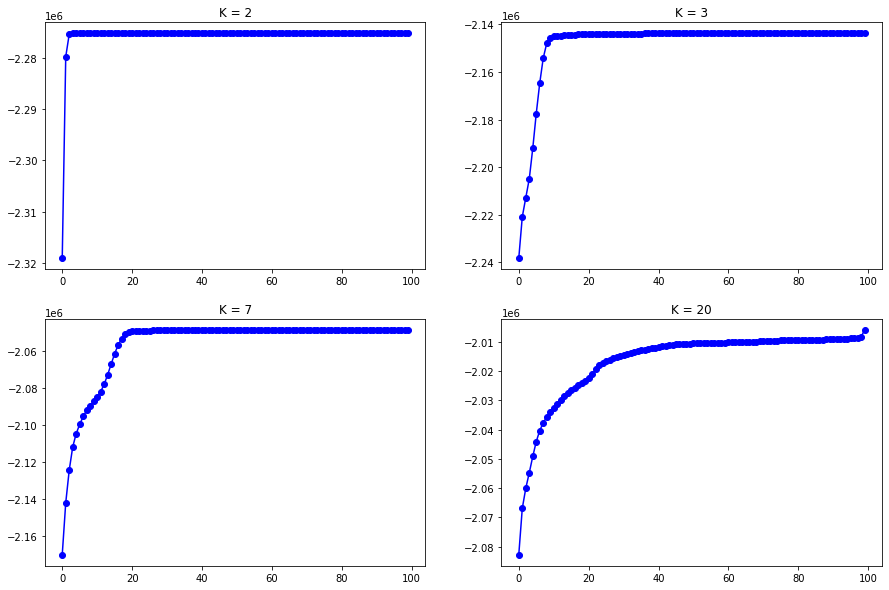

-----------means of K=2---------
[40.36619163 72.60651463 34.95208864]
[136.63812001 152.66774702 173.17131069]
-----------means of K=3---------
[16.88213078 52.20045611 22.51174899]
[66.10123874 95.11614773 48.60182692]
[135.69930083 151.71733556 172.06805807]
-----------means of K=7---------
[15.45096189 49.0147696  20.06175259]
[22.64742856 79.65005734 34.67930488]
[24.10606034 41.67017697 19.31609026]
[ 82.17348111 115.51485743  60.35559343]
[109.44020986 123.22951147 133.81869691]
[127.56490377 149.1961405  172.85526349]
[191.77882853 196.30932223 210.64229996]
-----------means of K=20---------
[19.64049052 31.49993655 15.79409637]
[12.77055773 36.73229175 16.53536664]
[24.82107728 46.78532845 28.69071579]
[16.57511255 54.56441075 21.91678923]
[22.72570023 79.77923971 34.71138364]
[32.83670966 56.61412976 23.85413042]
[60.39547096 89.17356011 41.46045518]
[ 79.97655602 111.49906287  56.24873378]
[101.34617408 137.00660607  74.70485595]
[ 93.79929553 132.4824959   75.34979468]
[ 97

In [27]:
fig, ax = plt.subplots(2,2)

for i in range(4):
    ax[i//2,i%2].set_title("K = {}".format(k_list[i]))
    ax[i//2,i%2].plot(range(len(likelihood_list[i])),likelihood_list[i],marker='o', color='blue',label="log likelihood")

fig.set_size_inches(15, 10)
plt.show()
cur=0
for k in k_list:
    print("-----------means of K={}---------".format(k))
    l=GMM_means_list[cur]
    for mean in l:
        print(mean)
    cur+=1

**Image of GMM**

In [28]:
def img_K(img,mean_list):
  N,M,_=img.shape
  ret=np.zeros((N,M,3))
  K=len(mean_list)
  for i in range(N):
    for j in range(M):
      cur_dist = [0 for i in range(K)]
      for k in range(K):
          cur_dist[k] = dist(img[i][j], mean_list[k])
      assignment = np.argmin(cur_dist)
      ret[i][j]=mean_list[assignment]
  return ret.astype("int32")


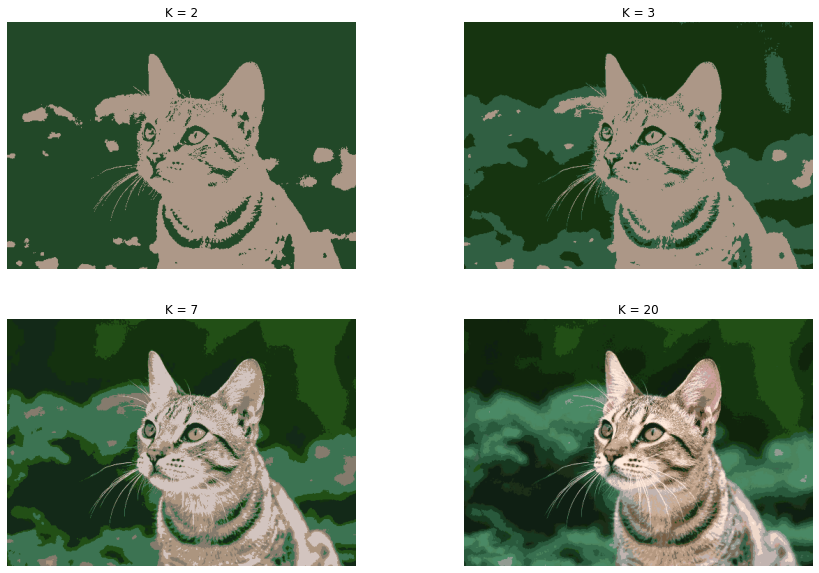

In [29]:
fig, ax = plt.subplots(2,2)

for i in range(4):
    ax[i//2,i%2].set_title("K = {}".format(k_list[i]))
    ax[i//2,i%2].imshow(img_K(img,GMM_means_list[i])[:,:,::-1]) #BGR to RGB
    ax[i//2,i%2].axis("off")
fig.set_size_inches(15, 10)
plt.show()

##4.Discussion
雖然兩種方法製造出的image乍看之下很相仿，但是仔細觀察會發現K-means的圖飽和度相對大，顏色的對比明顯，而GMM的顏色對比相較之下沒有那麼明顯，視覺效果相對柔和。  
可能是因為K_means是minimize pixel的distant 所以為了顧慮每個pixel(包括outlier)會得出平均分布且距離相對遙遠的means，距離遙遠的means就會產生顏色對比度大的視覺效果。
而GMM是最大化機率所以mean就會向大部分pixel的平均值靠攏，outlier的影響就會被降低，所以最後得到的mean就會是跟大部分pixel相近的顏色，產生顏色對比度小的柔和效果

#廢棄的code

In [30]:
subdata_list=[]
subtarget_list=[]
for i in range(3):
    subdata_list.append(data[label[0]==i])    #label==0 不行 (是dataframe不是series)
    subdata_list[i]=PCA(subdata_list[i].to_numpy(),2)
    N,D=subdata_list[i].shape
    subtarget_list.append(np.array([i for j in range(N)]))


In [31]:
t1=data[data[3]==0]
t2=data[label[0]==0] #label==0 不行 (是dataframe不是series)
t3=(data[3]==0)
t4=(label[0]==0)


In [32]:
#Using full Matrix multiplication is more appropriate
def predict(x,weight_list,bias_list):
    vote=np.zeros(3)
    y0=weight_list[0].reshape(1,-1)@x+bias_list[0]
    if y0>0:
        vote[0]+=1
    else:
        vote[1]+=1
    y1=weight_list[1].reshape(1,-1)@x+bias_list[1]
    if y1>0:
        vote[0]+=1
    else:
        vote[2]+=1
    y2=weight_list[2].reshape(1,-1)@x+bias_list[2]
    if y2>0:
        vote[1]+=1
    else:
        vote[2]+=1
    return np.argmax(vote)
for i in range(10):
    print(predict(data_pca[i],weight_list,bias_list))

ValueError: ignored

In [ ]:
"""
好像太平均
# initial assign
for i in range(N):
    for j in range(M):
        assign_map[i][j] = i % K
        assignment = int(assign_map[i][j])  # numpy to int
        sum_list[assignment] += img[i][j]
        count_list[assignment] += 1
mean_list = [sum_list[i]/count_list[i] for i in range(K)]
print(mean_list)
"""

In [ ]:
K=3
mean_list=means_list[1]
N,M,_ = img.shape
pi_list = [0]*K
data_subset=[[] for _ in range(K)]

for i in range(N):
    for j in range(M):
        cur_dist = [0 for i in range(K)]
        for k in range(K):
            cur_dist[k] = dist(img[i][j], mean_list[k])
        assignment = np.argmin(cur_dist)
        pi_list[assignment]+=1
        data_subset[assignment].append(img[i][j])
data_subset=[np.array(d) for d in data_subset]
#initial covariance       
pi_list=[pi/(N*M) for pi in pi_list]
cov_list=[0]*K
for k in range(K):
    tmp=data_subset[k].reshape(-1,3)
    cov_list[k]=np.cov(tmp.T)
print(cov_list)

#EM
likelihood_list=[]
pixels=img.reshape(-1,3)

print(mean_list)
#response
R=respons(pixels,pi_list,mean_list,cov_list)
#mean and pi
mean_list=[np.sum((R[:,k]*pixels.T).T,axis=0) for k in range(K)]
count_list=np.sum(R,axis=0)

mean_list=[mean_list[i]/count_list[i] for i in range(K)]
pi_list=count_list/sum(count_list)
print(mean_list)

#cov
vec_list=[pixels-mean_list[k] for k in range(K)]
cov_list=[R[:,k]*vec_list[k].T@vec_list[k]  for k in range(K)]
cov_list=[cov_list[k]/count_list[k] for k in range(K)]
print(cov_list)

log_likelihood(pixels,pi_list,mean_list,cov_list)